<a href="https://colab.research.google.com/github/shairatabassum/PyTorch_Learning/blob/main/PyTorch_III.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Learning with PyTorch** (part III)
A PyTorch notebook that I created while learning PyTorch through a series of tutorials on YouTube.

Source: [PyTorch Tutorials - Complete Beginner Course](https://www.youtube.com/watch?v=EMXfZB8FVUA&list=PLqnslRFeH2UrcDBWF5mfPGpqQDSta6VK4)

> **Table of contents**
> *  Digit Classification with Multi-layer Neural Network on MNIST Dataset
> *  Image Classification with Convolutional Neural Network (CNN) on the CIFAR-10 Dataset
> *  Transfer Learning on the ResNet-18 CNN pretrained on the ImageNet Dataset

### **Digit Classification with Multi-layer Neural Network on MNIST Dataset**

In [ ]:
# import libraries
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [ ]:
# hyper parameters
input_size = 784 #28x28
hidden_size = 100
num_classes = 10
num_epochs = 2
batch_size = 100
learning_rate = 0.001

In [ ]:
# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='.data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='.data/', train=False, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting .data/MNIST/raw/train-images-idx3-ubyte.gz to .data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting .data/MNIST/raw/train-labels-idx1-ubyte.gz to .data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting .data/MNIST/raw/t10k-images-idx3-ubyte.gz to .data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting .data/MNIST/raw/t10k-labels-idx1-ubyte.gz to .data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
# print one batch of the data
examples = iter(train_loader)
samples, labels = examples.next()
print(samples.shape, labels.shape)

torch.Size([100, 1, 28, 28]) torch.Size([100])


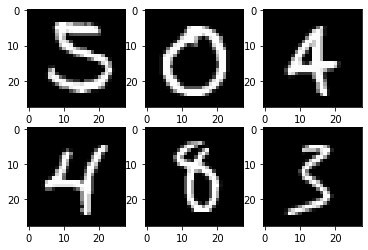

In [ ]:
for i in range(6):
  plt.subplot(2, 3, i+1)
  plt.imshow(samples[i][0], cmap='gray')
plt.show()

In [ ]:
# neural network model
class NeuralNet(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(NeuralNet, self).__init__()
    self.l1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.l2 = nn.Linear(hidden_size, num_classes)

  def forward(self, x):
    out = self.l1(x)
    out = self.relu(out)
    out = self.l2(out)
    return out

model = NeuralNet(input_size, hidden_size, num_classes)

In [ ]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# training loop
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    # shape: 100, 1, 28, 28
    # input size: 784
    # images tensor size should be: 100, 784
    images = images.reshape(-1, 28*28)
    labels = labels

    # forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)
    # backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i+1) % 100 == 0:
      print(f'epoch {epoch+1} / {num_epochs}, step {i+1}/{n_total_steps}, loss = {loss.item():.4f}')

epoch 1 / 2, step 100/600, loss = 0.5088
epoch 1 / 2, step 200/600, loss = 0.3769
epoch 1 / 2, step 300/600, loss = 0.4838
epoch 1 / 2, step 400/600, loss = 0.2182
epoch 1 / 2, step 500/600, loss = 0.3672
epoch 1 / 2, step 600/600, loss = 0.3456
epoch 2 / 2, step 100/600, loss = 0.2830
epoch 2 / 2, step 200/600, loss = 0.2077
epoch 2 / 2, step 300/600, loss = 0.1549
epoch 2 / 2, step 400/600, loss = 0.1893
epoch 2 / 2, step 500/600, loss = 0.1425
epoch 2 / 2, step 600/600, loss = 0.0782


In [ ]:
# evaluating model performance
with torch.no_grad():
  n_correct = 0
  n_samples = 0
  for images, labels in test_loader:
    images = images.reshape(-1, 28*28)
    labels = labels
    outputs = model(images)

    # value and index of predictions
    _, predictions = torch.max(outputs, 1)
    n_samples += labels.shape[0]
    n_correct += (predictions == labels).sum().item()

  accuracy = 100.0 * n_correct / n_samples
  print(f'accuracy = {accuracy}')

accuracy = 95.27


### **Image Classification with Convolutional Neural Network (CNN) on the CIFAR-10 Dataset**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# hyper parameters
num_epochs = 20
batch_size = 4
learning_rate = 0.001

In [ ]:
# CIFAR-10 dataset

# dataset has PILImage images of Range [0, 1]
# transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
# print one batch of the data
examples = iter(train_loader)
samples, labels = examples.next()
print(samples.shape, labels.shape)

torch.Size([4, 3, 32, 32]) torch.Size([4])


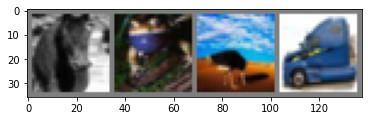

In [ ]:
def imshow(img):
  img = img / 2 + 0.5  # unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [ ]:
# convolutional neural network model
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)   # 3 color channels
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)      # 10 output classes

  def forward(self, x):
    # -> n, 3, 32, 32
    x = self.pool(F.relu(self.conv1(x)))  # -> n, 6, 14, 14
    x = self.pool(F.relu(self.conv2(x)))  # -> n, 16, 5, 5
    x = x.view(-1, 16 * 5 * 5)            # -> n, 400
    x = F.relu(self.fc1(x))               # -> n, 120
    x = F.relu(self.fc2(x))               # -> n, 84
    x = self.fc3(x)                       # -> n, 10
    return x

model = ConvNet()

**Formula to calculate the output size:**

```
(W - F + 2P) / S + 1
    W = input width
    F = filter size
    P = padding
    S = stride
```

**Initial input size:** 32 x 32

**Convolutional layer 1:** (3, 6, 5) --> **Output size:** 28 x 28

**Pooling layer:** (2, 2) --> **Output size:** 14 x 14

**Convolutional layer 2:** (6, 16, 5) --> 10 x 10

**Pooling layer:** (2, 2) --> **Output size:** 5 x 5


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [5, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images
        labels = labels

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 5000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [1/20], Step [5000/12500], Loss: 2.3137
Epoch [1/20], Step [10000/12500], Loss: 2.2774
Epoch [2/20], Step [5000/12500], Loss: 2.2759
Epoch [2/20], Step [10000/12500], Loss: 2.2510
Epoch [3/20], Step [5000/12500], Loss: 1.6347
Epoch [3/20], Step [10000/12500], Loss: 1.4304
Epoch [4/20], Step [5000/12500], Loss: 0.8432
Epoch [4/20], Step [10000/12500], Loss: 1.1785
Epoch [5/20], Step [5000/12500], Loss: 1.4624
Epoch [5/20], Step [10000/12500], Loss: 1.1195
Epoch [6/20], Step [5000/12500], Loss: 1.1982
Epoch [6/20], Step [10000/12500], Loss: 1.1671
Epoch [7/20], Step [5000/12500], Loss: 1.4552
Epoch [7/20], Step [10000/12500], Loss: 1.1267
Epoch [8/20], Step [5000/12500], Loss: 1.2791
Epoch [8/20], Step [10000/12500], Loss: 1.0570
Epoch [9/20], Step [5000/12500], Loss: 0.7355
Epoch [9/20], Step [10000/12500], Loss: 0.7265
Epoch [10/20], Step [5000/12500], Loss: 1.3412
Epoch [10/20], Step [10000/12500], Loss: 0.5378
Epoch [11/20], Step [5000/12500], Loss: 0.8985
Epoch [11/20], Step [

In [ ]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images
        labels = labels
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 67.66 %
Accuracy of plane: 70.0 %
Accuracy of car: 83.72 %
Accuracy of bird: 55.68 %
Accuracy of cat: 39.7 %
Accuracy of deer: 56.98 %
Accuracy of dog: 67.5 %
Accuracy of frog: 62.88 %
Accuracy of horse: 81.56 %
Accuracy of ship: 88.94 %
Accuracy of truck: 69.64 %


### **Transfer Learning on the ResNet-18 CNN pretrained on the ImageNet Dataset**
**Transfer Learning** is a machine learning method where a model developed for the first task is then reused as the starting point for a model on a second task. For example, we can train a model to classify birds and cats, then use the same model modified only a little bit in the last later to use it for classifying ants and bees. 

It is a popular approach in deep learning that allows rapid generation of new models, because training a completety new model from scratch can be very time consuming. So, if we use a pretrained model, then we typically exchange only the last layer and do not need to train the whole model again. However, transfer learning can achieve pretty good performance results as well.

**Data Source:** [Hymenoptera Dataset](https://download.pytorch.org/tutorial/hymenoptera_data.zip) [Ants and Bees]

In [ ]:
# import libraries 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [ ]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

data_transforms = {
    'train': transforms.Compose([
              transforms.RandomResizedCrop(224),
              transforms.RandomHorizontalFlip(),
              transforms.ToTensor(),
              transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
              transforms.Resize(256),
              transforms.CenterCrop(224),
              transforms.ToTensor(),
              transforms.Normalize(mean, std)
    ])
}

In [ ]:
# import data
# !unzip hymenoptera_data.zip
data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=0)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(class_names)

['ants', 'bees']


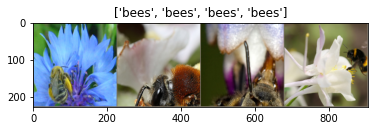

In [ ]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs
                labels = labels

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

**Technique 1: Fine-tuning**

Here, we load a pretrained model and reset the final fully-connected layer. The whole model is trained again by updating the weights based on the new dataset and the new last fully-connected layer.

In [ ]:
#### Finetuning the convnet ####

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 2)

model = model

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001)

# StepLR Decays the learning rate of each parameter group by gamma every step_size epochs
# Decay LR by a factor of 0.1 every 7 epochs
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=25)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth



Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 0.6356 Acc: 0.6270
val Loss: 0.4898 Acc: 0.7582

Epoch 1/24
----------
train Loss: 0.5190 Acc: 0.7295
val Loss: 0.3485 Acc: 0.9020

Epoch 2/24
----------
train Loss: 0.4809 Acc: 0.7869
val Loss: 0.2798 Acc: 0.9085

Epoch 3/24
----------
train Loss: 0.4175 Acc: 0.8074
val Loss: 0.2506 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.4401 Acc: 0.7869
val Loss: 0.2341 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.3579 Acc: 0.8443
val Loss: 0.2296 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.4260 Acc: 0.7992
val Loss: 0.2083 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.4136 Acc: 0.8197
val Loss: 0.2086 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3258 Acc: 0.8484
val Loss: 0.2046 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3899 Acc: 0.8115
val Loss: 0.2097 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3568 Acc: 0.8279
val Loss: 0.2262 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.3322 Acc: 0.8689
val Loss: 0.2027 Acc: 0.9477

Epoch 12/24
----------
t

**Technique 2: Fixed feature extractor**

Here, we need to freeze all the network from the beginning and only train the last final layer. We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward().

In [ ]:
#### ConvNet as fixed feature extractor ####

model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6872 Acc: 0.6721
val Loss: 0.2145 Acc: 0.9412

Epoch 1/24
----------
train Loss: 0.6491 Acc: 0.7295
val Loss: 0.2151 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.4054 Acc: 0.8402
val Loss: 0.2337 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.4806 Acc: 0.7992
val Loss: 0.1801 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.3374 Acc: 0.8689
val Loss: 0.2416 Acc: 0.9150

Epoch 5/24
----------
train Loss: 0.4325 Acc: 0.8074
val Loss: 0.3424 Acc: 0.8497

Epoch 6/24
----------
train Loss: 0.5252 Acc: 0.7951
val Loss: 0.2040 Acc: 0.9216

Epoch 7/24
----------
train Loss: 0.4747 Acc: 0.8115
val Loss: 0.1652 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.2685 Acc: 0.8730
val Loss: 0.1756 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.2898 Acc: 0.8730
val Loss: 0.1752 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3532 Acc: 0.8402
val Loss: 0.1768 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.4306 Acc: 0.8033
val Loss: 0.2299 Acc: 0.9216

Ep